# Calibration of the Grinsted (2007) SLR Model

## Load Environment

In [2]:
import Pkg
Pkg.activate(dirname(@__DIR__))
Pkg.instantiate()

  Activating project at `~/Teaching/BEE4850/website/slides`


In [3]:
using Distributions
using StatsBase
using CSV
using DataFrames
using Optim
using Turing
using Plots
using StatsPlots
using XLSX
using Interpolations

## Load Data

In [4]:
data_path = joinpath(dirname(@__DIR__), "data")
norm_yrs = 1951:1980

sl_dat = DataFrame(CSV.File(joinpath(data_path, "sealevel", "CSIRO_Recons_gmsl_yr_2015.csv")))

rename!(sl_dat, [:Year, :GMSLR, :SD]) # rename to make columns easier to work with
sl_dat[!, :Year] .-= 0.5 # shift year to line up with years instead of being half-year 
sl_dat[!, :GMSLR] .-= mean(filter(row -> row.Year ∈ norm_yrs, sl_dat)[!, :GMSLR]) # rescale to be relative to 1880-1900 mean for consistency with temperature anomaly
sl_dat


Row,Year,GMSLR,SD
,Float64,Float64,Float64
1,1880.0,-118.157,24.2
2,1881.0,-112.557,24.2
3,1882.0,-129.357,23.0
4,1883.0,-124.057,22.8
5,1884.0,-103.157,22.2
6,1885.0,-104.657,21.9
7,1886.0,-107.057,20.8
8,1887.0,-112.657,20.8
9,1888.0,-110.557,20.8


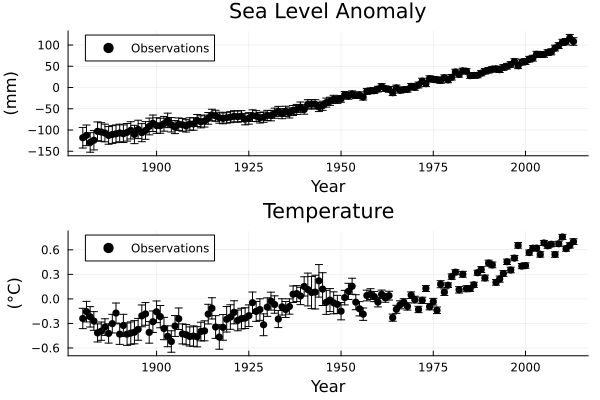

In [5]:

# load temperature data
temp_dat = DataFrame(CSV.File(joinpath(data_path, "climate", "HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv")))
rename!(temp_dat, [:Year, :Temp, :Lower, :Upper]) # rename to make columns easier to work with
filter!(row -> row.Year ∈ sl_dat[!, :Year], temp_dat) # reduce to the same years that we have SL data for
temp_normalize = mean(filter(row -> row.Year ∈ norm_yrs, temp_dat)[!, :Temp]) # get renormalization to rescale temperature to 1880-1900 mean
temp_dat[!, :Temp] .-= temp_normalize
temp_dat[!, :Lower] .-= temp_normalize
temp_dat[!, :Upper] .-=  temp_normalize

sl_plot = scatter(sl_dat[!, :Year], sl_dat[!, :GMSLR], yerr=sl_dat[!, :SD], color=:black, label="Observations", ylabel="(mm)", xlabel="Year", title="Sea Level Anomaly")

temp_plot = scatter(temp_dat[!, :Year], temp_dat[!, :Temp], yerr=(temp_dat[!, :Temp] - temp_dat[!, :Lower], temp_dat[!, :Upper] - temp_dat[!, :Temp]), color=:black, label="Observations", ylabel="(°C)", xlabel="Year", title="Temperature")

plot(sl_plot, temp_plot, layout=(2, 1))

## Model Specification

The Grinsted (2009) model is:

$$
\begin{align*}
\frac{S}{t} &= (S_\text{eq} - S) / \tau \\
S_\text{eq} &= aT + b
\end{align*}
$$

Discretizing:

$$S(t+1) = S(t) + \Delta t (S_\text{eq} - S(t)) / tau$$

We'll set $\Delta t = 1 \text{yr}$. This means we need the following parameters:

- $a$: Sensitivity of the equilibrium sea level to temperature ($mm / ^\circ C)$,
- $b$: Intercept of the equilibrium sea level $(mm)$.
- $\tau$: characteristic response time of SLR $(yr)$.
- $S_0$: initial SLR (mm)

This is the **generative model**.

Simplest way to add residuals/measurement errors:

$$y_t \sim N(H(t), \sigma^2)$$

For the initial $S_0$, we will assume that it is sampled within the observation error range of our initial datum.

In [11]:
function grinsted_slr(params, temps; Δt=1)
    a, b, τ, S₀ = params
    S = zeros(length(temps)) # initialize storage
    Seq = a * temps .+ b
    S[1] = S₀
    for i = 2:length(S)
        S[i] = S[i-1] +  Δt * (Seq[i] - S[i-1]) / τ
    end
    return S[1:end]
end

grinsted_slr (generic function with 1 method)

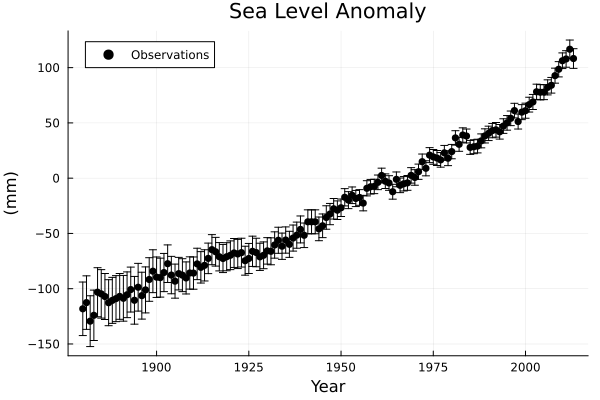

In [115]:
sl_plot = scatter(sl_dat[!, :Year], sl_dat[!, :GMSLR], yerr=sl_dat[!, :SD], color=:black, label="Observations", ylabel="(mm)", xlabel="Year", title="Sea Level Anomaly")


## Model Calibration 1: Gaussian iid Errors

In [87]:
# now the params include the standard deviation of the error model as well
function gaussian_iid_homosked(params, temp_dat, slr_dat, slr_err, Δt=1.0)
    a, b, τ, S₀, σ = params 
    slr_sim = grinsted_slr((a, b, τ, S₀), temp_dat; Δt = Δt)
    ll = sum(logpdf.(Normal.(slr_sim, sqrt.(σ^2 .+ slr_err.^2)), slr_dat))
    return ll
end

gaussian_iid_homosked((300, 300, 1000, -130, 500.0), temp_dat.Temp, sl_dat.GMSLR, sl_dat.SD)

-958.2663924655194

In [137]:
low_bds = [100.0, 100.0, 0.1, sl_dat.GMSLR[1] - 1.96 * sl_dat.SD[1], 0.0]
up_bds = [2000.0, 500.0, 2500.0, sl_dat.GMSLR[1] + 1.96 * sl_dat.SD[1], 100.0]
p₀ = [1000.0, 200.0, 1500.0, sl_dat.GMSLR[1], 10.0]

mle_optim = optimize(p -> -gaussian_iid_homosked(p, temp_dat.Temp, sl_dat.GMSLR, sl_dat.SD), low_bds, up_bds, p₀)
p_mle = mle_optim.minimizer

5-element Vector{Float64}:
  501.07951834395226
  232.98794739748413
  153.5152597351524
 -116.15042962289915
    1.5876803512850025e-9

In [89]:
p_mle[1] / p_mle[3]

2.9995976962072346

In [113]:
grinsted_homogauss_mle = grinsted_slr(p_mle, temp_dat.Temp)


134-element Vector{Float64}:
 -116.15042962289915
 -114.38415202252342
 -112.83594313076688
 -111.46410344339058
 -110.57724559352789
 -109.6269786457298
 -108.51898192916457
 -107.67241291681975
 -106.4416099983735
 -104.79618613721877
    ⋮
   82.16721174759903
   85.26853749514109
   88.4121629171821
   91.12387407610827
   94.24594038929142
   97.62050961608054
  100.5074045017997
  103.50575979243763
  106.63462600666074

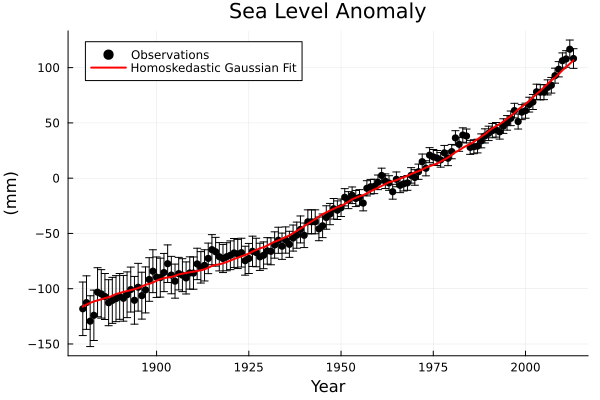

In [116]:
plot!(sl_plot, sl_dat[!, :Year], grinsted_homogauss_mle, color=:red, linewidth=2, label="Homoskedastic Gaussian Fit")

In [117]:
function gaussian_iid_ar(params, temp_dat, slr_dat, slr_err, Δt=1.0)
    a, b, τ, S₀, ρ, σ = params 
    slr_sim = grinsted_slr((a, b, τ, S₀), temp_dat; Δt = Δt)

    function ar_covariance_mat(σ, ρ, y_err)
        H = abs.((1:length(y_err)) .- (1:(length(y_err)))') # compute the outer product to get the correlation lags
        ζ_var = σ^2 / (1-ρ^2)
        Σ = ρ.^H * ζ_var
        for i in 1:length(y_err)
            Σ[i, i] += y_err[i]^2
        end
        return Σ
    end

    # whiten residuals
    Σ = ar_covariance_mat(σ, ρ, slr_err)
    residuals = slr_dat - slr_sim
    ll = logpdf(MvNormal(zeros(length(slr_dat)), Σ), residuals)
    return ll
end


gaussian_iid_ar (generic function with 2 methods)

In [118]:
low_bds = [100.0, 100.0, 0.1, sl_dat.GMSLR[1] - 1.96 * sl_dat.SD[1], 0.0, 0.0]
up_bds = [2000.0, 500.0, 2500.0, sl_dat.GMSLR[1] + 1.96 * sl_dat.SD[1], 1.0, 100.0]
p₀ = [1000.0, 200.0, 1500.0, sl_dat.GMSLR[1], 0.5, 10.0]

mle_optim = optimize(p -> -gaussian_iid_ar(p, temp_dat.Temp, sl_dat.GMSLR, sl_dat.SD), low_bds, up_bds, p₀)
p_mle2 = mle_optim.minimizer
@show p_mle;
@show p_mle2;

p_mle = [501.07951834395226, 232.98794739748413, 153.5152597351524, -116.15042962289915, 1.5876803512850025e-9]
p_mle2 = [501.3600842186349, 225.05444184458827, 148.4344696986154, -115.71523904227593, 0.8356669348293901, 1.2382701462341117]


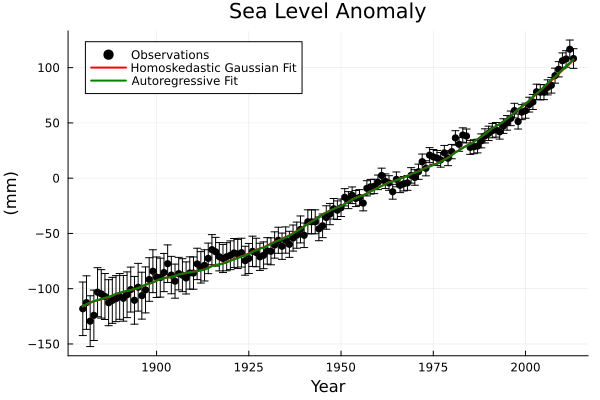

In [119]:
grinsted_ar_mle = grinsted_slr(p_mle2, temp_dat.Temp)
plot!(sl_plot, sl_dat[!, :Year], grinsted_ar_mle, color=:green, linewidth=2, label="Autoregressive Fit")

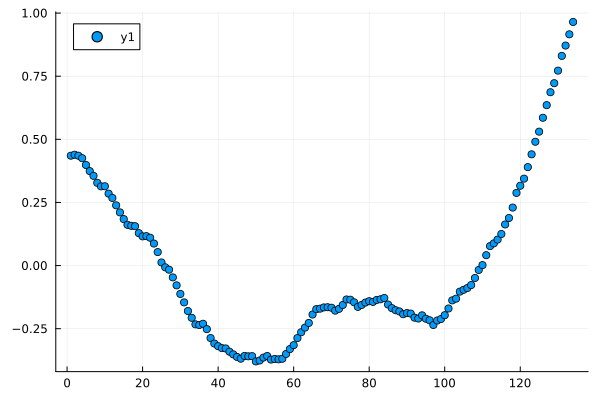

In [120]:
scatter(grinsted_ar_mle - grinsted_homogauss_mle)

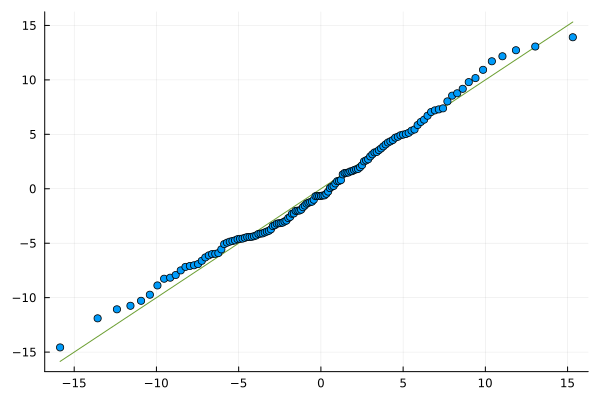

In [121]:
resids_homogauss = sl_dat.GMSLR - grinsted_homogauss_mle
qqnorm(resids_homogauss)


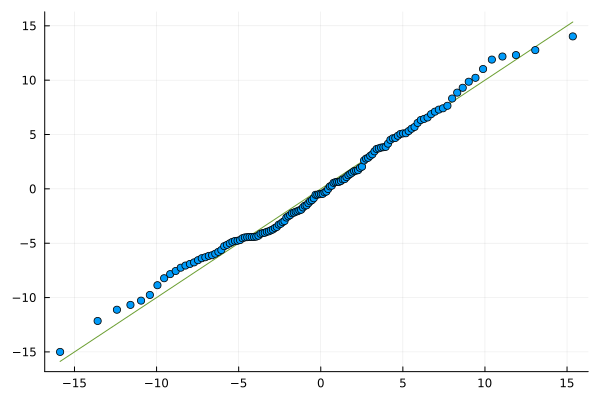

In [122]:
resids_ar = sl_dat.GMSLR - grinsted_ar_mle
qqnorm(resids_ar)

In [123]:
pacf_homogauss = pacf(resids_homogauss, 1:5)

5-element Vector{Float64}:
  0.5261374521380293
  0.0925853436990195
  0.051414462381828376
  0.055712327674993734
 -0.07107598741615423

In [124]:
pacf_ar = pacf(resids_ar, 1:5)

5-element Vector{Float64}:
  0.5274950120920945
  0.09552904396579409
  0.05339504219343216
  0.05763952707494303
 -0.06828824154117324

## Projections

In [125]:

rcpdf = XLSX.readtable(joinpath(data_path, "climate", "cmip6_temps.xlsx"), "data") |> DataFrame

# select only rows and columns with scenario names and data   
select!(rcpdf, Not([:Model, :Region, :Variable, :Unit, :Notes]))
rcpdf = rcpdf[1:5, :]


Row,Scenario,2005.0,2010.0,2020.0,2030.0,2040.0,2050.0,2060.0,2070.0,2080.0,2090.0,2100.0
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,SSP3-Baseline,0.913386,0.988055,1.22575,1.52381,1.86419,2.20251,2.55093,2.91152,3.28435,3.67242,4.0711
2,SSP4-Baseline,0.913386,0.988562,1.23721,1.53287,1.87389,2.21631,2.54615,2.87451,3.20099,3.49421,3.75829
3,SSP1-Baseline,0.913386,0.988441,1.22283,1.50579,1.77074,2.02206,2.24641,2.46035,2.66872,2.85621,3.01774
4,SSP2-Baseline,0.913386,0.988977,1.24141,1.48262,1.7615,2.05281,2.35626,2.68133,3.02315,3.38796,3.76329
5,SSP5-Baseline,0.913386,0.989124,1.2658,1.60296,2.01275,2.48049,2.9755,3.50379,4.0499,4.5757,5.05197


In [126]:
# reformat scenario names to SSPn-x.x
rcpdf[!, :Scenario] = first.(rcpdf[!, :Scenario], 4)
# sort by scenarios
sort!(rcpdf, :Scenario)

Row,Scenario,2005.0,2010.0,2020.0,2030.0,2040.0,2050.0,2060.0,2070.0,2080.0,2090.0,2100.0
,String,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,SSP1,0.913386,0.988441,1.22283,1.50579,1.77074,2.02206,2.24641,2.46035,2.66872,2.85621,3.01774
2,SSP2,0.913386,0.988977,1.24141,1.48262,1.7615,2.05281,2.35626,2.68133,3.02315,3.38796,3.76329
3,SSP3,0.913386,0.988055,1.22575,1.52381,1.86419,2.20251,2.55093,2.91152,3.28435,3.67242,4.0711
4,SSP4,0.913386,0.988562,1.23721,1.53287,1.87389,2.21631,2.54615,2.87451,3.20099,3.49421,3.75829
5,SSP5,0.913386,0.989124,1.2658,1.60296,2.01275,2.48049,2.9755,3.50379,4.0499,4.5757,5.05197


In [127]:
rcp_dat = zeros(nrow(rcpdf), 2100 - 1880 + 1)
split_idx = 2013 - 1880 + 1

134

In [128]:
rcp_dat[:, 1:split_idx] .= temp_dat.Temp'
rcp_dat

5×221 Matrix{Float64}:
 -0.239226  -0.15564  -0.218924  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.239226  -0.15564  -0.218924     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.239226  -0.15564  -0.218924     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.239226  -0.15564  -0.218924     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.239226  -0.15564  -0.218924     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [129]:

for (i, row) in enumerate(eachrow(rcpdf))
    yrs = collect(2013:2100)
    xs = collect(2010:10:2100)
    interp = LinearInterpolation(xs, collect(rcpdf[i, 3:end]))
    rcp_dat[i, split_idx:end] = interp.(yrs)
end
rcp_dat = DataFrame(rcp_dat, string.(collect(1880:2100)))
rcp_dat.Scenario = rcpdf.Scenario
rcp_dat

Row,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,-0.239226,-0.15564,-0.218924,-0.269868,-0.415714,-0.394518,-0.344298,-0.42218,-0.302773,-0.17329,-0.430252,-0.324709,-0.430953,-0.418013,-0.407158,-0.372146,-0.207401,-0.183194,-0.409186,-0.278828,-0.157873,-0.216823,-0.362378,-0.45672,-0.520955,-0.331145,-0.242533,-0.427552,-0.437265,-0.459159,-0.454418,-0.462599,-0.399067,-0.390547,-0.185986,-0.115238,-0.343604,-0.466414,-0.347978,-0.248912,-0.221975,-0.164071,-0.262622,-0.241325,-0.235456,-0.205819,-0.0462295,-0.152799,-0.130156,-0.316151,-0.100199,-0.0267918,-0.0688557,-0.245738,-0.0977309,-0.129453,-0.092915,0.057407,0.0644052,0.0358088,0.152542,0.114735,0.078012,0.08302,0.220711,0.119694,-0.0422069,-0.0145996,-0.0480553,-0.0671963,-0.150016,0.015452,0.0919605,0.154237,-0.0401443,-0.120704,-0.18656,0.041271,0.0589734,0.0286011,-0.0388811,0.0566085,0.0125515,0.0398,-0.229261,-0.127782,-0.0722787,-0.0409104,-0.0920264,0.0452392,-0.00850064,-0.129327,-0.0172212,0.126539,-0.0959314,-0.0341483,-0.139256,0.179694,0.0818617,0.167464,⋯
2,-0.239226,-0.15564,-0.218924,-0.269868,-0.415714,-0.394518,-0.344298,-0.42218,-0.302773,-0.17329,-0.430252,-0.324709,-0.430953,-0.418013,-0.407158,-0.372146,-0.207401,-0.183194,-0.409186,-0.278828,-0.157873,-0.216823,-0.362378,-0.45672,-0.520955,-0.331145,-0.242533,-0.427552,-0.437265,-0.459159,-0.454418,-0.462599,-0.399067,-0.390547,-0.185986,-0.115238,-0.343604,-0.466414,-0.347978,-0.248912,-0.221975,-0.164071,-0.262622,-0.241325,-0.235456,-0.205819,-0.0462295,-0.152799,-0.130156,-0.316151,-0.100199,-0.0267918,-0.0688557,-0.245738,-0.0977309,-0.129453,-0.092915,0.057407,0.0644052,0.0358088,0.152542,0.114735,0.078012,0.08302,0.220711,0.119694,-0.0422069,-0.0145996,-0.0480553,-0.0671963,-0.150016,0.015452,0.0919605,0.154237,-0.0401443,-0.120704,-0.18656,0.041271,0.0589734,0.0286011,-0.0388811,0.0566085,0.0125515,0.0398,-0.229261,-0.127782,-0.0722787,-0.0409104,-0.0920264,0.0452392,-0.00850064,-0.129327,-0.0172212,0.126539,-0.0959314,-0.0341483,-0.139256,0.179694,0.0818617,0.167464,⋯
3,-0.239226,-0.15564,-0.218924,-0.269868,-0.415714,-0.394518,-0.344298,-0.42218,-0.302773,-0.17329,-0.430252,-0.324709,-0.430953,-0.418013,-0.407158,-0.372146,-0.207401,-0.183194,-0.409186,-0.278828,-0.157873,-0.216823,-0.362378,-0.45672,-0.520955,-0.331145,-0.242533,-0.427552,-0.437265,-0.459159,-0.454418,-0.462599,-0.399067,-0.390547,-0.185986,-0.115238,-0.343604,-0.466414,-0.347978,-0.248912,-0.221975,-0.164071,-0.262622,-0.241325,-0.235456,-0.205819,-0.0462295,-0.152799,-0.130156,-0.316151,-0.100199,-0.0267918,-0.0688557,-0.245738,-0.0977309,-0.129453,-0.092915,0.057407,0.0644052,0.0358088,0.152542,0.114735,0.078012,0.08302,0.220711,0.119694,-0.0422069,-0.0145996,-0.0480553,-0.0

In [130]:
@show p_mle2;
@show p_mle;

p_mle2 = [501.3600842186349, 225.05444184458827, 148.4344696986154, -115.71523904227593, 0.8356669348293901, 1.2382701462341117]
p_mle = [501.07951834395226, 232.98794739748413, 153.5152597351524, -116.15042962289915, 1.5876803512850025e-9]


In [131]:
n = 10_000
yrs = 1880:2100
rahmstorf_iid_proj_ssp5 = zeros(n, length(yrs))
for i = 1:n 
    ε = rand(Normal(0, p_mle[end]), length(yrs))
    rahmstorf_iid_proj_ssp5[i, :] = grinsted_slr(p_mle[1:end-1], collect(rcp_dat[5, 1:end-1])) .+ ε
end
rahmstorf_iid_proj_q = mapslices(col -> quantile(col, [0.025, 0.5, 0.975]), rahmstorf_iid_proj_ssp5; dims=1)

3×221 Matrix{Float64}:
 -116.15  -114.384  -112.836  -111.464  …  801.193  813.671  826.223  838.848
 -116.15  -114.384  -112.836  -111.464     801.193  813.671  826.223  838.848
 -116.15  -114.384  -112.836  -111.464     801.193  813.671  826.223  838.848

In [132]:
rahmstorf_ar_proj_ssp5 = zeros(n, length(yrs))

H = abs.((1:length(yrs)) .- (1:(length(yrs)))') # compute the outer product to get the correlation lags
ζ_var = p_mle2[end]^2 / (1-p_mle2[end-1]^2)
Σ = p_mle2[end-1].^H * ζ_var

for i = 1:n 
    ε = rand(MvNormal(zeros(length(yrs)), Σ))
    rahmstorf_ar_proj_ssp5[i, :] = grinsted_slr(p_mle2[1:end-2], collect(rcp_dat[5, 1:end-1])) .+ ε
end
rahmstorf_ar_proj_q = mapslices(col -> quantile(col, [0.025, 0.5, 0.975]), rahmstorf_ar_proj_ssp5; dims=1)

3×221 Matrix{Float64}:
 -120.193  -118.349  -116.829  …  813.279  826.04   838.936  851.818
 -115.745  -113.908  -112.374     817.717  830.47   843.269  856.163
 -111.297  -109.506  -107.934     822.079  834.853  847.643  860.564

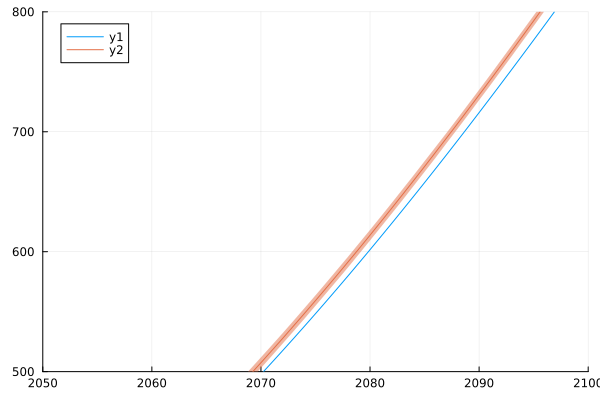

In [133]:
plot(1880:2100, rahmstorf_iid_proj_q[2, :], ribbon=(rahmstorf_iid_proj_q[2, :] - rahmstorf_iid_proj_q[1, :], rahmstorf_iid_proj_q[3, :] - rahmstorf_iid_proj_q[2, :]))
plot!(1880:2100, rahmstorf_ar_proj_q[2, :], ribbon=(rahmstorf_ar_proj_q[2, :] - rahmstorf_ar_proj_q[1, :], rahmstorf_ar_proj_q[3, :] - rahmstorf_ar_proj_q[2, :]))
ylims!((500, 800))
xlims!((2050, 2100))

In [134]:
plot(1880:2100, rahmstorf_iid_proj_ssp5 .- rahmstorf_ar_proj_ssp5)

ErrorException: Expects 221 elements in each col of y, found 10000.